In [99]:
from pickle import GLOBAL
import pinocchio as pin
import numpy as np
import time
import math
import sys
from numpy.linalg import norm, inv, pinv, det, matrix_rank
import pandas as pd

In [100]:
pinocchio_model_dir = '/home/unknown/Documents/Posdoc/ModelsCads/urdf' 
mesh_dir = pinocchio_model_dir + '/kinova_description/meshes/'
urdf_model_path =pinocchio_model_dir + '/j2s6s200_simple.urdf'
model, collision_model, visual_model = pin.buildModelsFromUrdf(urdf_model_path, mesh_dir)

In [101]:
frameIndex = model.getFrameId('j2s6s200_end_effector')
jointIndex = model.frames[frameIndex].parent
# Create data required by the algorithms
data     = model.createData()

In [102]:
def mprint(M, name="ans",eps=1e-15):
    '''
    Matlab-style pretty matrix print.
    '''
    if isinstance(M, pin.SE3):
        M = M.homogeneous
    if len(M.shape) == 1:
        M = np.expand_dims(M, axis=0)
    ncol = M.shape[1]
    NC = 6
    print(name, " = ")
    print()

    Mmin = lambda M: M.min()
    Mmax = lambda M: M.max()
    Mm = Mmin(abs(M[np.nonzero(M)]))
    MM = Mmax(abs(M[np.nonzero(M)]))

    fmt = "% 10.4f" if Mm < 1e-5 or MM > 1e6 or MM / Mm > 1e3 else "% 1.5f"
    for i in range(math.floor((ncol - 1) / NC + 1)):
        cmin = i * 6
        cmax = (i + 1) * 6
        cmax = ncol if ncol < cmax else cmax
        print("Columns %s through %s" % (cmin, cmax - 1))
        print()
        for r in range(M.shape[0]):
            sys.stdout.write("  ")
            for c in range(cmin, cmax):
                if abs(M[r,c])>eps: sys.stdout.write(fmt % M[r,c]  + "   ")
                else: sys.stdout.write(" 0"+" "*9)
            print()
        print()

In [475]:
def run_robot(): 

    def df_dq(model,func,q,h=1e-9):
        """ Perform df/dq by num_diff. q is in the lie manifold.
        :params func: function to differentiate f : np.matrix -> np.matrix
        :params q: configuration value at which f is differentiated. type np.matrix
        :params h: eps
        
        :returns df/dq
        """
        #print("in")
        dq = pin.utils.zero(model.nv)
        f0 = func(q)
        AM_i = pin.utils.zero([6,3,3])
        for iq in range(model.nv):
            dq[iq] = h
            res2 = (func(pin.integrate(model,q,dq)) - f0)/h
            AM_i[iq,:,:] = np.array([ [res2[0],res2[3],res2[4]], [res2[3],res2[1],res2[5]], [res2[4],res2[5],res2[2]] ])
            dq[iq] = 0
        return AM_i
    
    def calc_jac3(q):
        """ Compute Jacobian """
        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        pin.computeJointJacobians(model, data, q)
        J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED)
        Jbl = J[:3]
        R = Jbl@Jbl.T
        Rv = np.array([R[0][0],R[1][1], R[2][2], R[0][1], R[0][2], R[1][2]])                      
        return Rv.copy()

    # for runing the simulation
    t = 0
    dt = 5e-2
    Tf = 5
    N = math.floor(Tf/dt)
    q =np.array([0, 2.3, 1.3, np.pi, 1.2,0])
    df = pd.read_csv('qs_traj.csv')
    q1d = df.values[:,1];q2d = df.values[:,2];q3d = df.values[:,3]
    q4d = df.values[:,4];q5d = df.values[:,5];q6d = df.values[:,6]
    qdot_max = np.array([0.63, 0.63, 0.63, 0.84, 0.84,0.84]) #1,2,3 = 36 deg/s; 4,5,6 =48 deg/s 

    #md1 =15; md2 = 15;  md3 = 15
    #mds = np.array([md1, md2, md3])
    #Md = np.diag(mds) # Mass Matrix
    #Md_inv = np.linalg.pinv(Md)
    
    # for graphs
    E1_list = []
    E2_list = []
    Mdn_list = []
    kappa_list = []
    manu_list = []
    q_list = [] #q
    pose_list = []
    t_list = []
    d_list = []
    #manipaxes_list = []
    #manipaxesinv_list = []
    #a = np.arange(50,180,5) #(47,180,5)
    #b = np.arange(20,180,5) # (19,180,5)
    #c = np.arange(65,295,5)
    ## for runing the simulation
    for k in range(N):
        t += dt
        tic = time.time()
        q =np.array([q1d[k], q2d[k], q3d[k],q4d[k], q5d[k],q6d[k]])

        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        OM_act = data.oMf[frameIndex] # This is the pose of the end-effector refered in the frame of the base

        pin.computeJointJacobians(model, data, q)
        J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED) # in the base frame
        Jbl = J[:3] # linear part of the Jacobian
        
        dJ_dqn = df_dq(model,lambda _q: calc_jac3(_q),q)
        pos = np.array([OM_act.translation[0],OM_act.translation[1],OM_act.translation[2]])
        # is in the end effector (for simplicity) therefore, Je is gonna be J.
        xo=-0.35; yo =0; zo=0.4 # Position of the obstacle
        tau_q = 0.375
        tau_x = 0.3
        tau_alpha = tau_x/tau_q
        kappa_min = 1.1/(4*tau_alpha)
        P_o = np.array([xo,yo,zo])
        d = P_o.T - pos.T 
        I = np.identity(3)
        a = 1
        b= 2
        #kappa = kappa_min+a*np.exp(-b*d.T@d)
        kappa = np.exp(1/(d.T@d))
        #DKappa =  2*np.exp(-d.T@d)*d.T@Jbl@qdot_max
        Al = Jbl@Jbl.T
        Al_inv = inv(Al)
        Md = kappa*Al_inv

        Al_det = (det(Al))
        
        for i in range(6):
            dJ_dqn[i,:,:] = dJ_dqn[i]*qdot_max[i]

        #Upsilon = 4*(tau_x/tau_q)*(Jbl@Jbl.T)
        if Al_det < 1e-15:  
            Al_det = 0.0                
        if Al_det == 0.0:
            E_1 = math.nan
            E_2 = math.nan
        else:
            E_1 = norm(sum(dJ_dqn)*Al_inv)
            E_2 = norm(2*d.T@Jbl@qdot_max/(d.T@d)**2)#norm(2*b*d.T@Jbl@qdot_max)#norm(DKappa*I*1/kappa)
        Md_n = norm(Md)    
        manip_linear = np.sqrt(Al_det)
        
        d_list.append(norm(d))
        q_list.append(q)
        pose_list.append(pos)
        manu_list.append(manip_linear)
        E1_list.append(E_1)
        E2_list.append(E_2)
        Mdn_list.append(Md_n)
        t_list.append(t)
        kappa_list.append(kappa)
        toc = time.time()
        ellapsed = toc - tic
        dt_sleep = max(0,dt - (ellapsed))
        time.sleep(dt_sleep)
    d_list = np.array(d_list)     
    kappa_list = np.array(kappa_list) 
    t_list = np.array(t_list)            
    manu_list = np.array(manu_list)
    Mdn_list = np.array(Mdn_list)
    E1_list = np.array(E1_list)
    E2_list = np.array(E2_list)
    q_list = np.array(q_list)
    pose_list = np.array(pose_list)
    return  pose_list, q_list, manu_list, E1_list, E2_list, Mdn_list, t_list, kappa_list, d_list

In [476]:
pose, q, manip, E1, E2, Mdn, t, kappa, d, = run_robot()

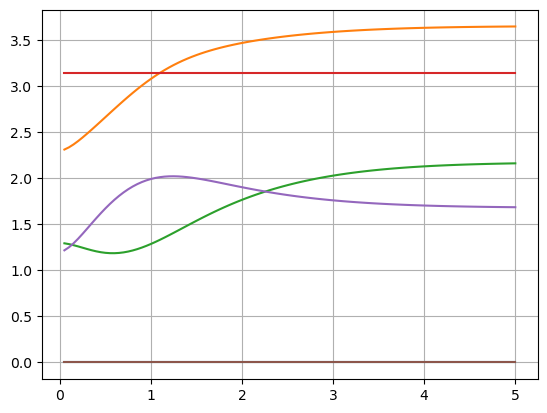

In [406]:
import matplotlib.pyplot as plt
plt.plot(t, q)
plt.grid(True)
plt.show()


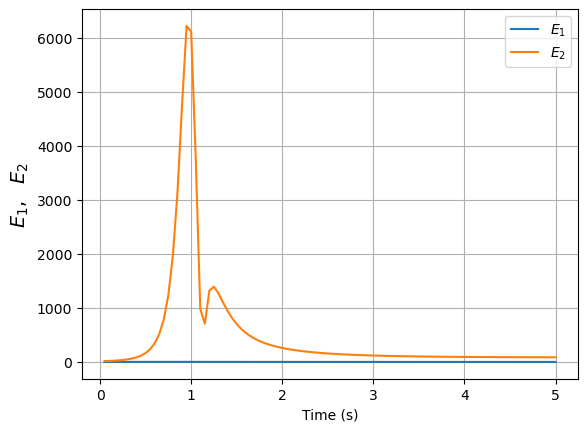

In [478]:
# Grahp E1, E2
fig, ax = plt.subplots()
#ax = plt.subplot(3, 2, 1)
plt.plot(t, E1)
plt.plot(t, E2)
ax.legend((r"$E_1$",r"$E_2$"),loc="upper right")
ax.set_ylabel(r"$ E_1,~~ E_2$", fontsize = 14)
ax.set_xlabel('Time (s)')

plt.grid(True)
plt.show()

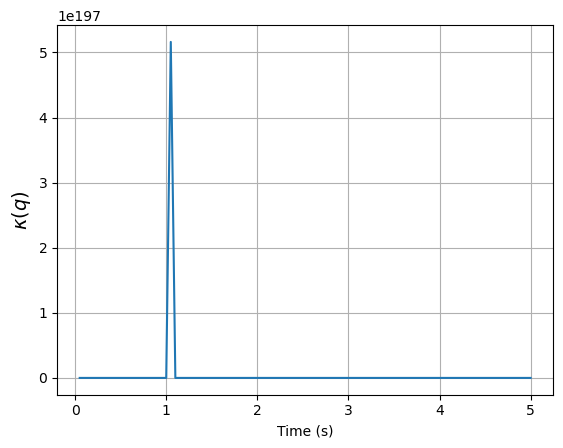

In [479]:
#Graph kappa
fig, ax = plt.subplots()
#ax = plt.subplot(3, 2, 1)
plt.plot(t, kappa)
ax.set_ylabel(r"$\kappa(q)$", fontsize = 14)
ax.set_xlabel('Time (s)')

plt.grid(True)
plt.show()

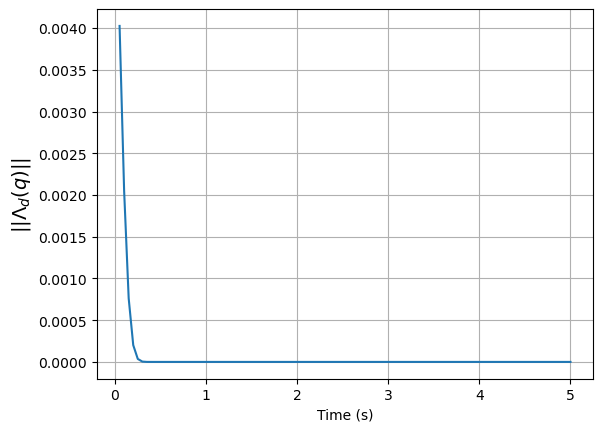

In [472]:
fig, ax = plt.subplots()
#ax = plt.subplot(3, 2, 1)
plt.plot(t, Mdn)
ax.set_ylabel(r"$ || \Lambda_d(q) || $", fontsize = 14)
ax.set_xlabel('Time (s)')

plt.grid(True)
plt.show()

In [ ]:
pd.DataFrame(pose).to_csv('pose_workspace_v2.csv', index_label = "Index", header  = ['x','y','z'])    

In [ ]:
pd.DataFrame(manip).to_csv('manip_workspace_v2.csv', index_label = "Index", header  = ['manip'])    

In [ ]:
pd.DataFrame(q).to_csv('qs_workspace_v2.csv', index_label = "Index", header  = ['q1','q2','q3','q4','q5','q6'])    

In [ ]:

pd.DataFrame(E1).to_csv('E1_workspace5_v2.csv', index_label = "Index", header  = ['E1'])    

In [ ]:
pd.DataFrame(E2).to_csv('E2_workspace5_v2.csv', index_label = "Index", header  = ['E2'])    

In [ ]:
pd.DataFrame(Mdn).to_csv('Md_workspace5_v2.csv', index_label = "Index", header  = ['Md'])    

### Constraints to verify
$$
{\kappa}{(q)} > \frac{1}{4 {\tau}_{\alpha} }
$$
$$

    \left\lVert  \frac{\partial{({J} {J}^T)}}{\partial{{q}_i}} ({J} {J}^T)^{-1} \right\rVert_{2} > \left\lVert   \frac{\partial{{\kappa}{(q)}}}{\partial{{q}_i}} {I}  \frac{1}{{\kappa}{(q)}}\right\rVert_{2}
$$
Let us propose
$$
    {\kappa}{(q)} = \exp{ \left\lVert {d} \right\rVert^2}
$$
therefore, it derivative is expressed by
$$
    \frac{\partial{{\kappa}{(q)}}}{\partial{{q}_i}} = -2\exp{({d}^T {d})} {d}^T {J}_e .
$$
and $J_e = \left[ \frac{\partial{{p}_e}}{\partial{{q}_1}}, \cdots, \frac{\partial{{p}_e}}{\partial{{q}_n}} \right]$ and ${d} = {p}_o - {p}_e$ is the distance between the 
obstacle position ${p}_o$ and the current position ${p}_e$ of the ToF sensor. 

In [ ]:
def df_dq(model,func,q,h=1e-9):
    """ Perform df/dq by num_diff. q is in the lie manifold.
    :params func: function to differentiate f : np.matrix -> np.matrix
    :params q: configuration value at which f is differentiated. type np.matrix
    :params h: eps
    
    :returns df/dq
    """
    dq = pin.utils.zero(model.nv)
    f0 = func(q)
    #print(f0)
    AM_i = pin.utils.zero([6,3,3])
    for iq in range(model.nv-1):
        dq[iq] = h
        res = (func(pin.integrate(model,q,dq)) - f0)/h 
        #print(res)
        AM_i[iq,:,:] = np.array([ [res[0],res[3],res[4]], [res[3],res[1],res[5]], [res[4],res[5],res[2]] ])
        dq[iq] = 0
    return AM_i.copy()

In [438]:
from numpy.linalg import eig
q = np.array([0, 2.9, 1.3, -2.07, 1.4,0]) # Natural position as in the real case
qdot_max = np.array([0.63, 0.63, 0.63, 0.84, 0.84,0.84]) #1,2,3 = 36 deg/s; 4,5,6 =48 deg/s 
pin.computeJointJacobians(model, data, q)
J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED) # in the base frame
Jbl = J[:3] # linear part of the Jacobian

pin.forwardKinematics(model,data,q)
pin.updateFramePlacements(model,data)
OM_act = data.oMf[frameIndex] # This is the pose of the end-effector refered in the frame of the base

P_e = np.array([OM_act.translation[0],OM_act.translation[1],OM_act.translation[2]]) #Here we suppose the ToF sensor
# is in the end effector (for simplicity) therefore, Je is gonna be J.
xo=0.5; yo =0.5; zo=0.5 # Position of the obstacle
P_o = np.array([xo,yo,zo])
d = P_o.T - P_e.T 
kappa = np.exp(-norm(d)**2)
DKappa =  2*np.exp(-norm(d)**2)*d.T@Jbl@qdot_max
Md = kappa*inv(Jbl@Jbl.T)
#a = 20
#b =0.5
tau_q = 0.375
tau_x = 0.3
tau_alpha = tau_x/tau_q
kappa_min = 1/(4*tau_alpha)
I = np.identity(3)

def calc_jac3(q):
     """ Compute Jacobian """
     pin.forwardKinematics(model,data,q)
     pin.updateFramePlacements(model,data)
     pin.computeJointJacobians(model, data, q)
     J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED)
     Jbl = J[:3]
     R = Jbl@Jbl.T
     Rv = np.array([R[0][0],R[1][1], R[2][2], R[0][1], R[0][2], R[1][2]])      
     #print(Rv)                
     return Rv.copy()

dJ_dq = df_dq(model,lambda _q: calc_jac3(_q),q)
Al_inv = inv(Jbl@Jbl.T)

for i in range(6):
     dJ_dq[i,:,:] = dJ_dq[i]*qdot_max[i]

E_1 = norm(sum(dJ_dq)*Al_inv)
E_2 = norm(DKappa*I*1/kappa)
print("E_1 =", E_1)
print("E_2 =", E_2)
print("Kappa =", kappa)
print("DKappa =", DKappa)

#otro = 2*d.T@Jbl@qdot_max/(d.T@d)**2
#otro2=2*d.T@Jbl@qdot_max
#print(otro)
#print(otro2)

E_1 = 3.272702821874932
E_2 = 0.5721267957814903
Kappa = 0.5930814405657225
DKappa = -0.19590521406505784
-1.2102808579723427
-0.3303175595550414


In [188]:
4*np.exp(1*-5)

0.026951787996341868